# TMP91FW27UG Bootloader SPA

In this lab, we'll be looking at the [TMP91FW27UG](https://toshiba.semicon-storage.com/us/semiconductor/product/microcontrollers/detail.TMP91FW27UG.html) device. You can find a link to the [datasheet PDF here](https://toshiba.semicon-storage.com/info/docget.jsp?did=10173&prodName=TMP91FW27UG), or there is a local copy on the USB stick.

Our objective is to bypass the security mechanism of this device, so take a look at the datasheet and try to udnerstand what type of code protection the device has. When researcing this, it can help to search for keywords like "security", "fuse", "password", "readback", "code security", "read out", or "bootloader". Different manufactures use different technologies or words.

Try to understand the following before continuing:

1. What built-in bootloader or programming method is included in the device?
2. Can you access the ROM for the bootloader? How much detail is there in the datasheet? Is there anything they might be lieing about?
3. What access control level is part of the protection mechanism?
4. What pin(s) do we need to control for the bootloader?

## Talking to the Bootloader

In order to talk to the bootloader, we included a TMP91FW27UG target board. This board includes the TMP91FW27UG microcontroller. You can see the schematic and design for this board [here](https://github.com/newaetech/chipwhisperer-target-cw308t/tree/main/CW312T_TMP91FW) if you wish.

The important points about the pinout are:

1. The clock is driven from the ChipWhisperer, using the normal "clkgen" output.
2. The serial is connected as `tio1 = "serial_tx"`, `tio2 = "serial_rx"`
3. The BOOT pin is `pdic`, set it low (`False`) for bootloader, high (`True`) for normal boot

The following small snippets may be helpful: one shows how to calculate the checksum required, the other sends a command and returns the response. The response is returned in two formats (sometimes you'll want one or the other).

You may need to modify these commands further in your own code.

In [1]:
def calc_checksum(r):
    s = 0
    for c in r:
        s += c
    cs = 0x100 - (s & 0xff)
    return cs

def tx_rx(cmd, expectedlen=0, rxlen=100):
    target.ser.write(cmd)
    response = target.ser.read(rxlen)
    if expectedlen:
        if len(response) != expectedlen:
            raise IOError("Unexpected response length %d (data: %s)"%(len(response), str(response)))

    responsehex = [ord(c) for c in response]
    return response, responsehex

## Selecting a Command

There are several bootloader commands to choose from, as shown in the table here:

| Name                     | Command | Needs Password? | Protection Bit Blocked? |
|--------------------------|---------|-----------------|-------------------------|
| RAM Transfer             | 0x10    | ?               | ?                       |
| Flash memory SUM         | 0x20    | No              | ?                       |
| Product Information Read | 0x30    | ?               | ?                       |
| Chip Erase               | 0x40    | No              | No                      |
| Protection Bit Set       | 0x60    | ?               | ?                       |

Try to fill in the rest of the "Needs Passwrd" and "Protection Bit Blocked" columns. It will help you understand the most useful command for doing a SPA attack.

**HINT**: You want a command which requires the password but isn't blocked by the protection bit. There is one suitable command only in the particular bootloader. If we didn't have such a command, we'd need to perform a fault injection attack to bypass the protection bit.

Once you have a command, you can see the general flow of the command structure from the datasheet. You'll need some code to do the following:

1. Set the BOOT flag as required.
2. Reset the device.
3. Send the required command, check the response.

To write to the device, you'll need to send hex data like e.g.:

```
target.ser.write([0x86])
```

When you read data, you can specify how many bytes to read. Remember there might be garbage in the serial line, so you might need to clear the output by tring to read too much data first:

```
target.ser.read(1000)
```

Or use the flush command:

```
target.ser.flush()
```

So a typical code-flow should look like:

```
import time
scope.io.pdic = ?
scope.io.nrst = False
time.sleep(0.1)
scope.io.nrst = True
time.sleep(0.1)
target.ser.flush() # This flushes old data out
target.ser.write([0x86])
data = target.ser.read(1)
print(data)
```

You might notice the `data` is just a string. You can convert it to a list with different commands. Try converting to `bytes` or `bytearray`. You can force this to just print as a list with:

```
[ord(c) for c in data]
```

The `ord(c)` function converts an ascii char into an integer. You can also convert this to  hex by wrapping in the `hex()` or a formatting call, such as:

```
['%02x'%ord(c) for c in data]
```

See the following examples of the conversion of a single character:

In [2]:
ord('a')

97

In [4]:
'%02x'%ord('a')

'61'

Try adding your code here to talk to the device. We've given you the required setup code to start with:

In [6]:
PLATFORM = ""
%run ../Setup_Scripts/Setup_Generic.ipynb

scope.clock.clkgen_freq = 25E6 #25 MHz on examples
target.baud = 9600 #9600 baud rate
scope.io.tio1 = "serial_tx"
scope.io.tio2 = "serial_rx"

INFO: Found ChipWhisperer😍
scope.gain.mode                          changed from low                       to high                     
scope.gain.gain                          changed from 0                         to 22                       
scope.gain.db                            changed from 15.0                      to 25.091743119266056       
scope.adc.samples                        changed from 131124                    to 5000                     
scope.adc.trig_count                     changed from 1234                      to 17840456                 
scope.clock.clkgen_freq                  changed from 0                         to 7370129.87012987         
scope.clock.adc_freq                     changed from 0                         to 29480519.48051948        
scope.io.tio1                            changed from serial_tx                 to serial_rx                
scope.io.tio2                            changed from serial_rx                 to serial_tx         

## Triggering & Plotting SPA Attempt

Next, we need to do a SPA attempt. To do this, we're going to trigger on `tio1`, which is the serial line. This will work because we simply trigger on the serial data we are sending to the device, which is the first byte of the password.

We can look at more complex triggering methods later on.

In [28]:
scope.trigger.triggers = "tio1"
scope.clock.adc_mul = 1
scope.adc.offset = 0
scope.adc.samples = 100000

In [29]:
%matplotlib notebook
import matplotlib.pylab as plt

In [30]:
raise NotImplementedError ("Add your Code here instead, delete this")

# You need to add the code here to set PDIC to the right value & reset it from above.

<IPython.core.display.Javascript object>


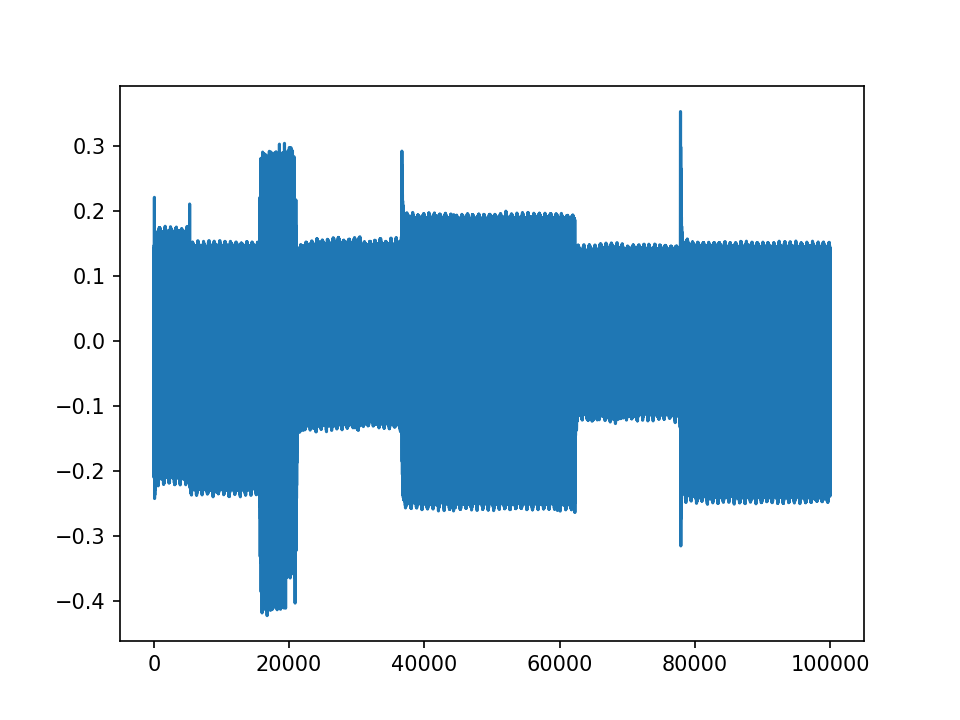

In [31]:
scope.arm()
target.ser.write([0x86])
scope.capture()
trace = scope.get_last_trace()
plt.plot(trace)

What you've done above is just trigger on the initial sync packet (assuming you left the code as-is). In which case you'll get something like this:

![](img/tmp91boot.png)

What you need to do now is use that to trigger on the **password** being sent. To start with, make a `reset_target()` function to simplify the loop which resets the device each time:

In [33]:
def reset_target():
    scope.io.nrst = False
    time.sleep(0.05)
    scope.io.nrst = True
    time.sleep(0.05)

Then try making a small loop to test some different first characters of the password. Here's an example starting point for the loop.

Modify it to correctly setup the function you identified above, and then plot the actual password comparison. At this point things won't syncronize well, so we'll work on that afterwards.

<IPython.core.display.Javascript object>


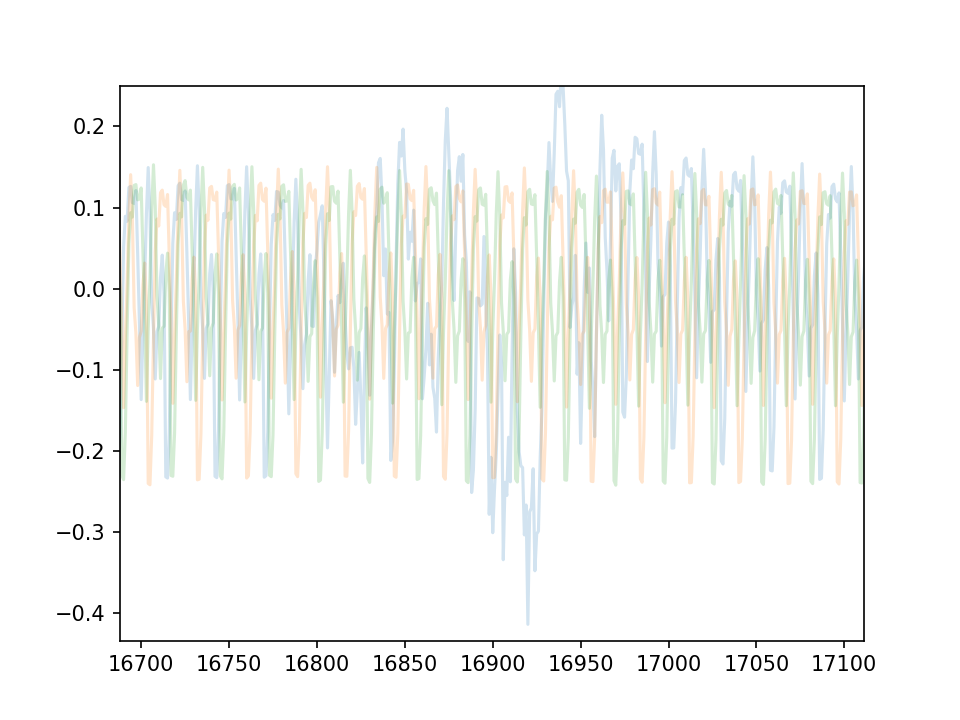

In [37]:
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
from tqdm.notebook import trange, tqdm

plt.figure()

for i in range(20, 23):
    reset_target()
    target.ser.flush()
    
    raise NotImplementedError("Setup the bootloader each time here - on the next sent byte we trigger, so do all the normal stuff")
    
    scope.arm()
    target.ser.write(str(chr(i)))
    scope.capture()
    trace = scope.get_last_trace()
      
    plt.plot(trace, alpha=0.5)

Things will look unsyncronized which is the big problem. For example, when running it my test looked like this:

![](img/tmp91unsync.png)

## Resync with Software

One of the problems above is you need to resyncronize the power traces. We'll do this with a simple software routine here. Doing this will require us to:

1. Manually decide on what looks like an interesting point. Luckily that is easy in this example.
2. Pass the interesting points to the following function, along with traces we want to resyncronize.
3. Plot the resyncronized traces.


In [48]:
def resync_sad(trace, ref, ref_range, pad=True, copy=True):
    _, offset = sad(trace, ref, ref_range)
    
    if copy:
        inlen = len(trace)
        output = np.zeros(inlen)
        output[:(inlen - offset)] = trace[offset:]
    else:
        raise NotImplementedError("Not Yet Implemented")
    
    return output
    

def sad(full_trace, pattern, pattern_range=None, valid_only=True):
    
    tlen = len(full_trace)
    
    psum = np.zeros(tlen)
    temp = np.zeros(tlen)
    
    if pattern_range:
        plen = pattern_range[1] - pattern_range[0]
        pstart = pattern_range[0]
    else:
        plen = len(pattern)
        pstart = 0
        

    for j in range(plen-1, -1, -1):
        #NB - due to way we index through array, don't need to reset this back to zero
        #temp = np.zeros(100000)
        np.subtract(full_trace[j:], pattern[pstart+j], out=temp[0:(100000-j)])
        psum += abs(temp)

    if valid_only:
        psum = psum[0:-plen]
    
    offset = np.argmin(psum)    
    offset = np.argmin(psum) - pattern_range[0] + (pattern_range[1] - pattern_range[0])
    
    return psum, offset

<IPython.core.display.Javascript object>


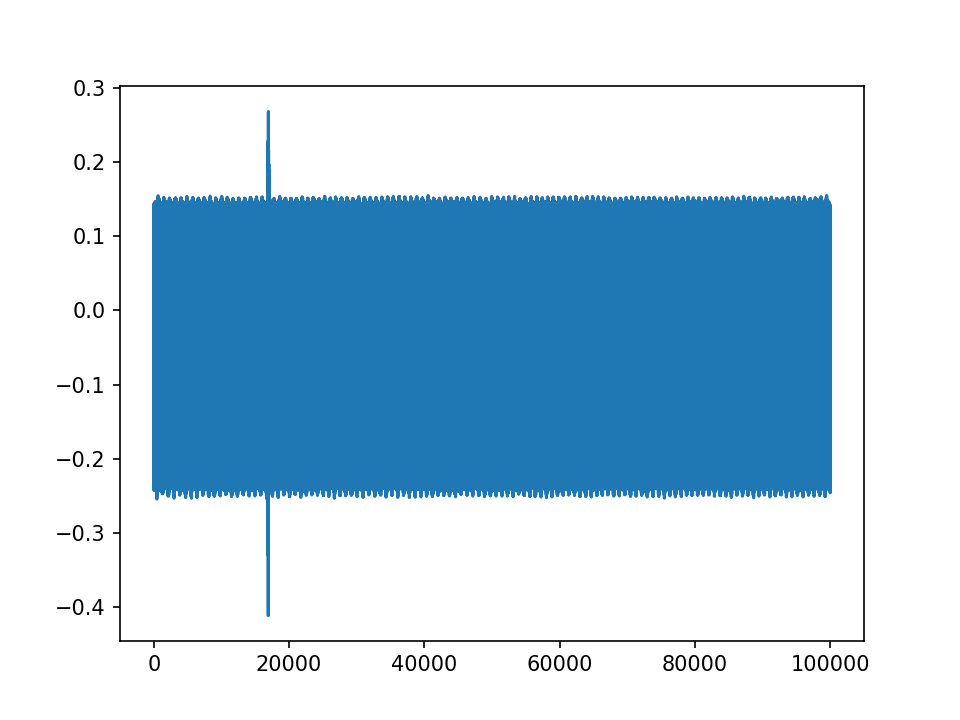

In [51]:
plt.figure()
plt.plot(trace)

<IPython.core.display.Javascript object>


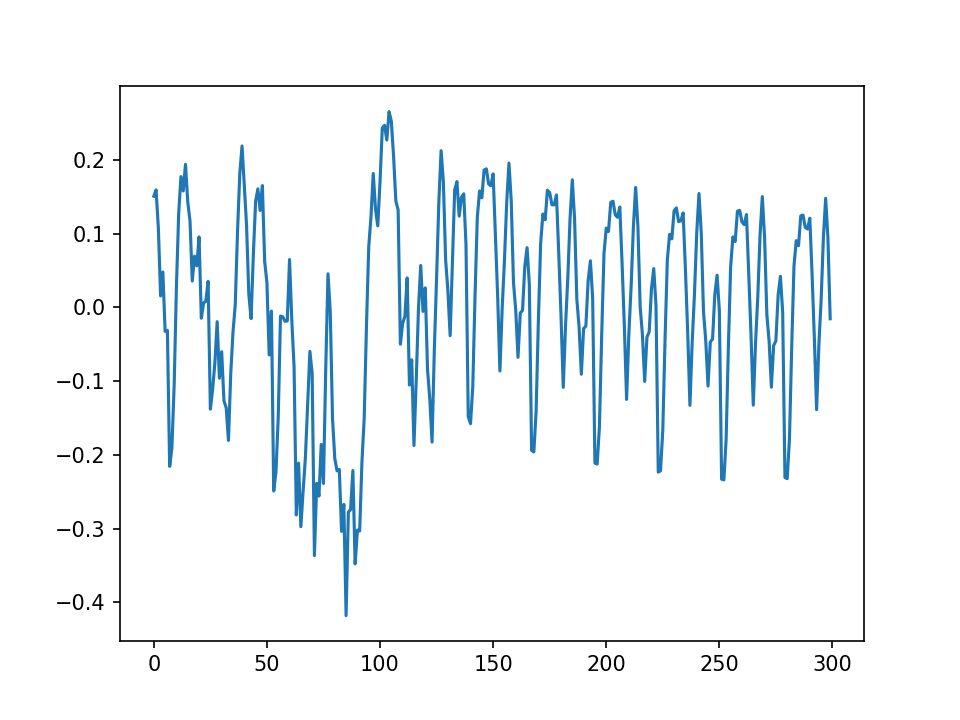

In [54]:
plt.figure()
start = 16800 #ADJUST THIS
end = 17100 #ADJUST THIS
trace1 = trace
plt.plot(trace1[start:end])

Adjust the above start & end parameters until you get a nice-looking `trace1`. For example, something like this should be in your view:

![](img/tmp91resync1.png)

Finally, run code like the following and see if it resyncronized all the traces:

14 0.687256


<IPython.core.display.Javascript object>


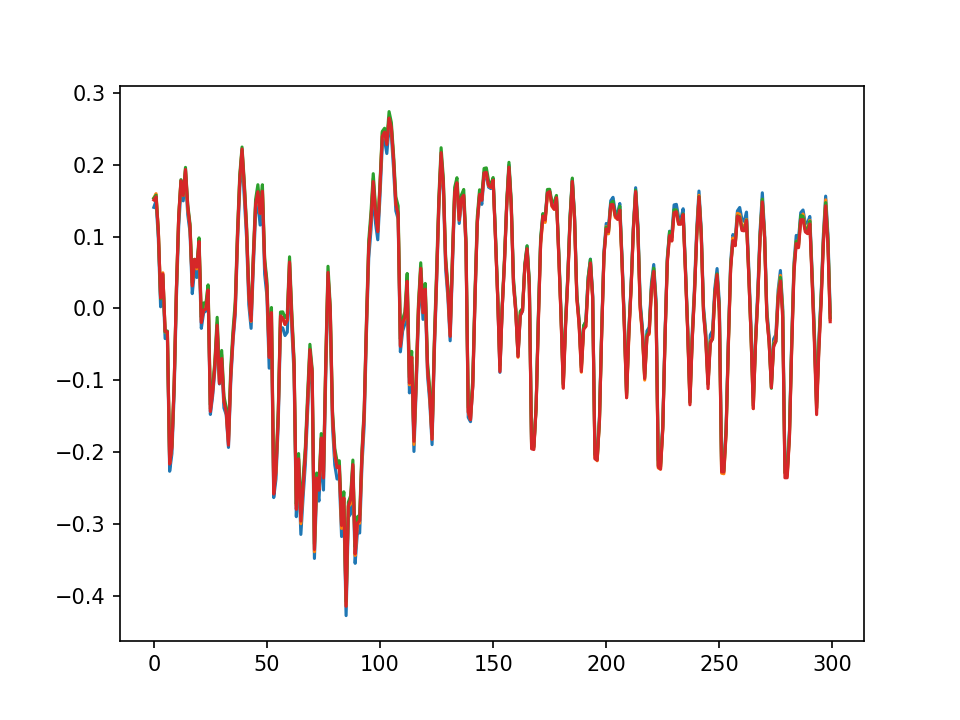

15 0.162109
16 0.825928
17 0.228027


In [56]:
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
from tqdm.notebook import trange, tqdm

go = True

i = 0

diffs = []
traces = []

for i in range(20, 24):
    reset_target()
    target.ser.flush()
    raise NotImplementedError("Requires your code here!")
        
    scope.arm()
    target.ser.write(str(chr(i)))
    scope.capture()
    trace = scope.get_last_trace()
    
    #NOTE - you'll need to adjust the -300 number currently to target the center of the actual work
    
    #try:
    trace = resync_sad(trace, trace1, (start,end))[start-300:end-300]
    #except ValueError:
    #    continue
    
    diff_trace = trace - trace1[start:end]
    traces.append(trace)
    
    diff = np.sum(abs(diff_trace)[80:180])
    diffs.append(diff)
    print("%x %f"%(i, diff))
    
    plt.plot(trace)

## SPA Attempt with Software

With the syncronization working, you now need to script the full attack. You'll notice in the previous example it started to print the deltas between `trace1` and the guess - this might be a good starting point for the full attack!

If you get stuck, see the Answers notebook. You can also steal some of the code from the following notebook: https://github.com/colinoflynn/samsung-ovens-deconstructed/blob/master/notebooks/Oven%20TMP91%20Hacky%20Test.ipynb